In [2]:
# The code was removed by Watson Studio for sharing.

# Segmenting and Clustering Neighborhoods in Toronto

## Part 1

### Using the beautifulsoup package to scrape the Wikipedia page:

In [4]:
#import libraries
from bs4 import BeautifulSoup
import requests
import pandas as pd

# locate relevant data on Wikipedia
source = requests.get('https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M').text
soup = BeautifulSoup(source, 'lxml')
table = soup.find('table')

#create empty dataframe
df = pd.DataFrame()

# copy data into the empty dataframe
for entry in table.find_all('tr'):
    line = pd.DataFrame([entry.text.splitlines()])
    df = df.append(line)
    
df.head()

,0,1,2,3
0,,Postcode,Borough,Neighbourhood
0,,M1A,Not assigned,Not assigned
0,,M2A,Not assigned,Not assigned
0,,M3A,North York,Parkwoods
0,,M4A,North York,Victoria Village


### Cleaning data:

In [5]:
# reset index
df.reset_index(drop=True, inplace=True)
# set the column headers to equal the first row
df.columns = df.iloc[0]
# drop first row as it contains header names
df = df.drop([0]).reset_index(drop=True)
df.head()

,,Postcode,Borough,Neighbourhood
0,,M1A,Not assigned,Not assigned
1,,M2A,Not assigned,Not assigned
2,,M3A,North York,Parkwoods
3,,M4A,North York,Victoria Village
4,,M5A,Downtown Toronto,Harbourfront


In [6]:
# remove all entries for which Borough is not assigned
df = df[df['Borough'] != 'Not assigned'].reset_index(drop=True)
df.head()

,,Postcode,Borough,Neighbourhood
0,,M3A,North York,Parkwoods
1,,M4A,North York,Victoria Village
2,,M5A,Downtown Toronto,Harbourfront
3,,M6A,North York,Lawrence Heights
4,,M6A,North York,Lawrence Manor


In [7]:
# combine neighbourhoods in the same borough
df = df.groupby(['Postcode','Borough'])['Neighbourhood'].apply(lambda x: ', '.join(x)).reset_index()
df.head()

,Postcode,Borough,Neighbourhood
0,M1B,Scarborough,"Rouge, Malvern"
1,M1C,Scarborough,"Highland Creek, Rouge Hill, Port Union"
2,M1E,Scarborough,"Guildwood, Morningside, West Hill"
3,M1G,Scarborough,Woburn
4,M1H,Scarborough,Cedarbrae


In [8]:
# checking for 'Not assigned' neighbourhoods
df[df['Neighbourhood'].str.contains('Not assigned')]

,Postcode,Borough,Neighbourhood


In [9]:
# return number of rows in df
print('Number of rows in dataframe: {}'.format(df.shape[0]))

Number of rows in dataframe: 103


### Adding latitude and longitude values to dataframe:

In [10]:
# read the csv file with co-ordinates into a new dataframe
coordinate_data = pd.read_csv('https://cocl.us/Geospatial_data')
coordinate_data.head()

,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


In [11]:
# Add the co-ordinates to the neighbourhood dataframe
df = df.join(coordinate_data.set_index('Postal Code'), on='Postcode')
df.head()

,Postcode,Borough,Neighbourhood,Latitude,Longitude
0,M1B,Scarborough,"Rouge, Malvern",43.806686,-79.194353
1,M1C,Scarborough,"Highland Creek, Rouge Hill, Port Union",43.784535,-79.160497
2,M1E,Scarborough,"Guildwood, Morningside, West Hill",43.763573,-79.188711
3,M1G,Scarborough,Woburn,43.770992,-79.216917
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476


In [12]:
pd.unique(df['Borough'])

array(['Scarborough', 'North York', 'East York', 'East Toronto',
       'Central Toronto', 'Downtown Toronto', 'York', 'West Toronto',
       'Mississauga', 'Etobicoke'], dtype=object)

## Part 2

### Installing necessary packages

In [192]:
!pip install geocoder
print('Geocoder installed!')

Geocoder installed!


In [193]:
!pip install folium
print('folium installed!')

folium installed!


In [146]:
import folium
import geocoder
from geopy.geocoders import Nominatim
from sklearn.cluster import KMeans
import numpy as np
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import seaborn as sns

### I will only analyse boroughs that contain the word 'Toronto' to simplify the modelling process

In [112]:
# creating a dataframe that olny contains boroughs with 'Toronto in the title'
toronto_data = df[df['Borough'].apply(lambda x: x.endswith('Toronto'))].reset_index(drop=True)
toronto_data.head()

,Postcode,Borough,Neighbourhood,Latitude,Longitude
0,M4E,East Toronto,The Beaches,43.676357,-79.293031
1,M4K,East Toronto,"The Danforth West, Riverdale",43.679557,-79.352188
2,M4L,East Toronto,"The Beaches West, India Bazaar",43.668999,-79.315572
3,M4M,East Toronto,Studio District,43.659526,-79.340923
4,M4N,Central Toronto,Lawrence Park,43.728020,-79.388790


Using Geolocator to get the geopgraphical coordinates of Toronto:

In [17]:
address = 'Toronto'

geolocator = Nominatim(user_agent="toronto_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Toronto are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Toronto are 43.653963, -79.387207.


### Create a map of Toronto with neighborhoods superimposed on top:

In [113]:
# create map of New York using latitude and longitude values
map_toronto = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough, neighbourhood in zip(toronto_data['Latitude'], toronto_data['Longitude'], toronto_data['Borough'], toronto_data['Neighbourhood']):
    label = '{}, {}'.format(neighbourhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  
    
map_toronto

The following cell contains Foursquare credentials and is hidden.

In [195]:
# The code was removed by Watson Studio for sharing.

An API request will be sent to Foursquare to find the top 100 venues that are within a radius of 500 meters from each neighbourhood.

In [196]:
# set radius and distance limit
radius = 500
LIMIT = 100

Function that extracts the category of the venue:

In [21]:
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

Function to get venue infomation for all neighbourhoods in Toronto:

In [22]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighbourhood', 
                  'Neighbourhood Latitude', 
                  'Neighbourhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

Running the above function on each neighborhood and creating a new dataframe called toronto_venues:

In [115]:
toronto_venues = getNearbyVenues(names=toronto_data['Neighbourhood'],
                                   latitudes=toronto_data['Latitude'],
                                   longitudes=toronto_data['Longitude']
                                  )

The Beaches
The Danforth West, Riverdale
The Beaches West, India Bazaar
Studio District
Lawrence Park
Davisville North
North Toronto West
Davisville
Moore Park, Summerhill East
Deer Park, Forest Hill SE, Rathnelly, South Hill, Summerhill West
Rosedale
Cabbagetown, St. James Town
Church and Wellesley
Harbourfront
Ryerson, Garden District
St. James Town
Berczy Park
Central Bay Street
Adelaide, King, Richmond
Harbourfront East, Toronto Islands, Union Station
Design Exchange, Toronto Dominion Centre
Commerce Court, Victoria Hotel
Roselawn
Forest Hill North, Forest Hill West
The Annex, North Midtown, Yorkville
Harbord, University of Toronto
Chinatown, Grange Park, Kensington Market
CN Tower, Bathurst Quay, Island airport, Harbourfront West, King and Spadina, Railway Lands, South Niagara
Stn A PO Boxes 25 The Esplanade
First Canadian Place, Underground city
Christie
Dovercourt Village, Dufferin
Little Portugal, Trinity
Brockton, Exhibition Place, Parkdale Village
High Park, The Junction Sout

Saving toronto_venues to csv for future use to prevent repeat API requests:

In [117]:
# save dataframe to 
project.save_data(file_name = "toronto_venues.csv",data = toronto_venues.to_csv(index=False), overwrite=True)

{'file_name': 'toronto_venues.csv',
 'message': 'File saved to project storage.',
 'bucket_name': 'ibmdatasciencecapstoneproject-donotdelete-pr-fzpo45gg751c0q',
 'asset_id': 'd0c4d6c5-fba8-4753-86bc-9b34b86a4217'}

In [33]:
# code to open the file if needed
toronto_venues = project.get_file(file_name = "toronto_venues.csv")
toronto_venues = pd.read_csv(toronto_venues)
toronto_venues.head()

### Examining the data

In [118]:
print(toronto_venues.shape)
toronto_venues.head()

(1719, 7)


,Neighbourhood,Neighbourhood Latitude,Neighbourhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,The Beaches,43.676357,-79.293031,Glen Manor Ravine,43.676821,-79.293942,Trail
1,The Beaches,43.676357,-79.293031,The Big Carrot Natural Food Market,43.678879,-79.297734,Health Food Store
2,The Beaches,43.676357,-79.293031,Grover Pub and Grub,43.679181,-79.297215,Pub
3,The Beaches,43.676357,-79.293031,Upper Beaches,43.680563,-79.292869,Neighborhood
4,"The Danforth West, Riverdale",43.679557,-79.352188,Pantheon,43.677621,-79.351434,Greek Restaurant


In [119]:
toronto_venues.groupby('Neighbourhood').count()
print('There are {} uniques categories.'.format(len(toronto_venues['Venue Category'].unique())))

There are 235 uniques categories.


### Data processing

In [120]:
# one hot encoding
toronto_onehot = pd.get_dummies(toronto_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
toronto_onehot['Neighbourhood'] = toronto_venues['Neighbourhood'] 

# move neighborhood column to the first column
fixed_columns = [toronto_onehot.columns[-1]] + list(toronto_onehot.columns[:-1])
toronto_onehot = toronto_onehot[fixed_columns]

toronto_onehot.head()

,Neighbourhood,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,...,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio
0,The Beaches,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
1,The Beaches,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,The Beaches,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,The Beaches,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,"The Danforth West, Riverdale",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Grouping rows by neighborhood and by taking the mean of the frequency of occurrence of each category

In [121]:
toronto_grouped = toronto_onehot.groupby('Neighbourhood').mean().reset_index()
toronto_grouped.head(5)

,Neighbourhood,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,...,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio
0,"Adelaide, King, Richmond",0.0,0.0000,0.0000,0.0000,0.000,0.000,0.0000,0.02,0.0,...,0.0,0.0,0.020000,0.0,0.0,0.01,0.0,0.0,0.01,0.000000
1,Berczy Park,0.0,0.0000,0.0000,0.0000,0.000,0.000,0.0000,0.00,0.0,...,0.0,0.0,0.017241,0.0,0.0,0.00,0.0,0.0,0.00,0.000000
2,"Brockton, Exhibition Place, Parkdale Village",0.0,0.0000,0.0000,0.0000,0.000,0.000,0.0000,0.00,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.00,0.0,0.0,0.00,0.000000
3,Business Reply Mail Processing Centre 969 Eastern,0.0,0.0000,0.0000,0.0000,0.000,0.000,0.0000,0.00,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.00,0.0,0.0,0.00,0.058824
4,"CN Tower, Bathurst Quay, Island airport, Harbo...",0.0,0.0625,0.0625,0.0625,0.125,0.125,0.0625,0.00,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.00,0.0,0.0,0.00,0.000000


### Comparing the top 10 venues for each neighborhood.

In [122]:
# function to sort the venues in descending order
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [175]:
# creating a new dataframe and displaying the top 10 venues for each neighborhood
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighbourhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighbourhoods_venues_sorted = pd.DataFrame(columns=columns)
neighbourhoods_venues_sorted['Neighbourhood'] = toronto_grouped['Neighbourhood']

for ind in np.arange(toronto_grouped.shape[0]):
    neighbourhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(toronto_grouped.iloc[ind, :], num_top_venues)

neighbourhoods_venues_sorted.head()

,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"Adelaide, King, Richmond",Coffee Shop,Café,Restaurant,Bar,Thai Restaurant,Sushi Restaurant,Steakhouse,Cosmetics Shop,Burger Joint,Asian Restaurant
1,Berczy Park,Coffee Shop,Cocktail Bar,French Restaurant,Cheese Shop,Café,Restaurant,Seafood Restaurant,Beer Bar,Bakery,Farmers Market
2,"Brockton, Exhibition Place, Parkdale Village",Café,Breakfast Spot,Coffee Shop,Pet Store,Italian Restaurant,Intersection,Stadium,Bar,Burrito Place,Bakery
3,Business Reply Mail Processing Centre 969 Eastern,Yoga Studio,Spa,Auto Workshop,Brewery,Burrito Place,Comic Shop,Farmers Market,Fast Food Restaurant,Garden,Garden Center
4,"CN Tower, Bathurst Quay, Island airport, Harbo...",Airport Lounge,Airport Service,Sculpture Garden,Boat or Ferry,Airport,Airport Food Court,Airport Gate,Airport Terminal,Harbor / Marina,Rental Car Location


### Clustering Neighbourhoods

Using the elbow method to determine the optimal value for k.

Text(0, 0.5, 'Error')

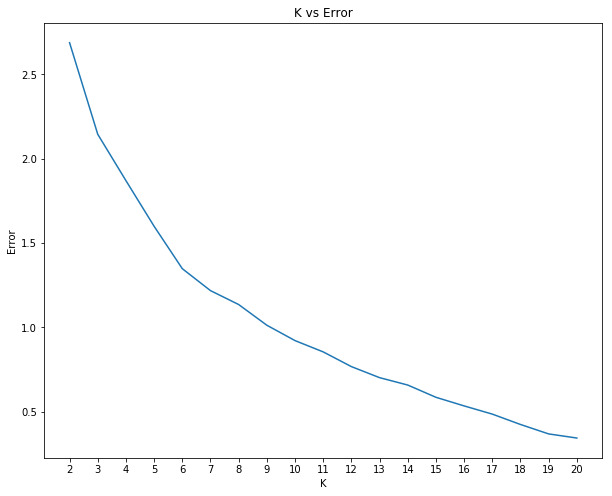

In [179]:
toronto_grouped_clustering = toronto_grouped.drop('Neighbourhood', 1)

def get_inertia(n_clusters):
    km = KMeans(n_clusters=n_clusters, init='k-means++', max_iter=15, random_state=2)
    km.fit(toronto_grouped_clustering)
    return km.inertia_

scores = [get_inertia(x) for x in range(2, 21)]

plt.figure(figsize=[10, 8])
sns.lineplot(x=range(2, 21), y=scores)
plt.title("K vs Error")
plt.xticks(range(2, 21))
plt.xlabel("K")
plt.ylabel("Error")

The above graph shows that the optimal k = 6, as the error sharply increases after this point.

Running *k*-means to cluster the neighborhood into 6 clusters:

In [181]:
# set number of clusters
kclusters = 6

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=2).fit(toronto_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32)

Creating a new dataframe that includes the cluster as well as the top 10 venues for each neighborhood:

In [182]:
# add clustering labels
neighbourhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

toronto_merged = toronto_data

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
toronto_merged = toronto_merged.join(neighbourhoods_venues_sorted.set_index('Neighbourhood'), on='Neighbourhood')

toronto_merged.head() # check the last columns!

,Postcode,Borough,Neighbourhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,M4E,East Toronto,The Beaches,43.676357,-79.293031,4,Trail,Neighborhood,Health Food Store,Pub,Yoga Studio,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Donut Shop
1,M4K,East Toronto,"The Danforth West, Riverdale",43.679557,-79.352188,0,Greek Restaurant,Coffee Shop,Italian Restaurant,Ice Cream Shop,Furniture / Home Store,Bookstore,Brewery,Cosmetics Shop,Caribbean Restaurant,Bubble Tea Shop
2,M4L,East Toronto,"The Beaches West, India Bazaar",43.668999,-79.315572,0,Sandwich Place,Pet Store,Pub,Brewery,Liquor Store,Burrito Place,Fast Food Restaurant,Fish & Chips Shop,Italian Restaurant,Steakhouse
3,M4M,East Toronto,Studio District,43.659526,-79.340923,0,Café,Coffee Shop,Gastropub,American Restaurant,Bakery,Brewery,Italian Restaurant,Yoga Studio,Pet Store,Park
4,M4N,Central Toronto,Lawrence Park,43.728020,-79.388790,3,Park,Bus Line,Swim School,Yoga Studio,Diner,Event Space,Ethiopian Restaurant,Electronics Store,Eastern European Restaurant,Dumpling Restaurant


Visualising clusters:

In [183]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(toronto_merged['Latitude'], toronto_merged['Longitude'], toronto_merged['Neighbourhood'], toronto_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

## Examining clusters

#### Cluster one: urban cafes, bars and restaurants

In [184]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 0, toronto_merged.columns[[2] + list(range(5, toronto_merged.shape[1]))]]

,Neighbourhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,"The Danforth West, Riverdale",0,Greek Restaurant,Coffee Shop,Italian Restaurant,Ice Cream Shop,Furniture / Home Store,Bookstore,Brewery,Cosmetics Shop,Caribbean Restaurant,Bubble Tea Shop
2,"The Beaches West, India Bazaar",0,Sandwich Place,Pet Store,Pub,Brewery,Liquor Store,Burrito Place,Fast Food Restaurant,Fish & Chips Shop,Italian Restaurant,Steakhouse
3,Studio District,0,Café,Coffee Shop,Gastropub,American Restaurant,Bakery,Brewery,Italian Restaurant,Yoga Studio,Pet Store,Park
5,Davisville North,0,Gym,Hotel,Park,Breakfast Spot,Sandwich Place,Department Store,Food & Drink Shop,Dog Run,Doner Restaurant,Donut Shop
6,North Toronto West,0,Clothing Store,Coffee Shop,Yoga Studio,Diner,Dessert Shop,Café,Chinese Restaurant,Mexican Restaurant,Salon / Barbershop,Restaurant
7,Davisville,0,Sandwich Place,Pizza Place,Dessert Shop,Coffee Shop,Italian Restaurant,Gym,Sushi Restaurant,Café,Farmers Market,Seafood Restaurant
9,"Deer Park, Forest Hill SE, Rathnelly, South Hi...",0,Coffee Shop,Pub,Bagel Shop,Fried Chicken Joint,Liquor Store,Sports Bar,Restaurant,Supermarket,Sushi Restaurant,Light Rail Station
11,"Cabbagetown, St. James Town",0,Coffee Shop,Pizza Place,Restaurant,Italian Restaurant,Café,Bakery,Pub,Market,Ice Cream Shop,Beer Store
12,Church and Wellesley,0,Coffee Shop,Japanese Restaurant,Gay Bar,Restaurant,Sushi Restaurant,Pub,Men's Store,Mediterranean Restaurant,Hotel,Gym
13,Harbourfront,0,Coffee Shop,Pub,Bakery,Park,Breakfast Spot,Restaurant,Mexican Restaurant,Café,Theater,Hotel


#### Cluster two: outlier - activities

In [185]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 1, toronto_merged.columns[[2] + list(range(5, toronto_merged.shape[1]))]]

,Neighbourhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
22,Roselawn,1,Garden,Yoga Studio,Dim Sum Restaurant,Falafel Restaurant,Event Space,Ethiopian Restaurant,Electronics Store,Eastern European Restaurant,Dumpling Restaurant,Donut Shop


#### Cluster three: outdoors

In [186]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 2, toronto_merged.columns[[2] + list(range(5, toronto_merged.shape[1]))]]

,Neighbourhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
10,Rosedale,2,Park,Playground,Trail,Yoga Studio,Dim Sum Restaurant,Event Space,Ethiopian Restaurant,Electronics Store,Eastern European Restaurant,Dumpling Restaurant
23,"Forest Hill North, Forest Hill West",2,Park,Jewelry Store,Trail,Sushi Restaurant,Yoga Studio,Diner,Event Space,Ethiopian Restaurant,Electronics Store,Eastern European Restaurant


#### Cluster four: outlier - outdoor, activities and cultural restaurants

In [187]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 3, toronto_merged.columns[[2] + list(range(5, toronto_merged.shape[1]))]]

,Neighbourhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
4,Lawrence Park,3,Park,Bus Line,Swim School,Yoga Studio,Diner,Event Space,Ethiopian Restaurant,Electronics Store,Eastern European Restaurant,Dumpling Restaurant


#### Cluster five: discount food and stores with outdoors

In [188]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 4, toronto_merged.columns[[2] + list(range(5, toronto_merged.shape[1]))]]

,Neighbourhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,The Beaches,4,Trail,Neighborhood,Health Food Store,Pub,Yoga Studio,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Donut Shop


#### Cluster six: children's activities

In [189]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 5, toronto_merged.columns[[2] + list(range(5, toronto_merged.shape[1]))]]

,Neighbourhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
8,"Moore Park, Summerhill East",5,Playground,Trail,Summer Camp,Yoga Studio,Dim Sum Restaurant,Event Space,Ethiopian Restaurant,Electronics Store,Eastern European Restaurant,Dumpling Restaurant
